In [1]:
import pandas as pd
import geopandas as gd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

Setup and read data. The data is not included in this repo. Data is expected to be located in ../data/skyhook/ directory.

In [2]:
skyhook_col_types = {
"tide5id_100m" : str,
"mac_oui" : str,
"ssid" : str,
"lat" : float,
"lon" : float ,
"rq_time" : str, # we parse this as date with parse_dates parameter in read_csv call later
"zcta" : int,
"zcta_city" : str,
"zcta_county" : str,
"zcta_state" : str
}

skyhook_data = pd.read_csv("../data/skyhook/p1059_nau_oui_20210301.csv", dtype=skyhook_col_types, parse_dates=['rq_time'])

Read in Hopi shape and subset samples to those that lie within

In [3]:
tribal_areas_path = '../data/tl_2019_us_aiannh/tl_2019_us_aiannh.shp'

tribal_areas = gd.read_file(tribal_areas_path)
tribal_areas.set_index('AIANNHCE', inplace=True)

# 1505 is the AIANNHCE ID of the Hopi reservation
# from https://www2.census.gov/geo/docs/reference/codes/AIAlist.txt
hopi = tribal_areas.loc["1505"]

In [5]:
# EPSG:4326 is global lat/lon coordinates, we set this to begin with, then reproject into the correct coordinates from other data
skyhook_gdf = gd.GeoDataFrame(skyhook_data, geometry=gd.points_from_xy(skyhook_data.lon, skyhook_data.lat)).set_crs("EPSG:4326").to_crs(hopi.crs)

In [6]:
skyhook_hopi = gd.overlay(skyhook_gdf, hopi, how="intersection")

Summary statistics of times of measurements and counts.

In [7]:
skyhook_data[['rq_time']].describe(datetime_is_numeric=True)

,rq_time
count,1291723
mean,2020-09-17 07:06:19.692180224
min,2019-09-07 00:04:19
25%,2020-05-20 19:33:33.500000
50%,2020-10-29 23:15:28
75%,2021-02-21 01:56:43.500000
max,2021-03-07 23:59:52


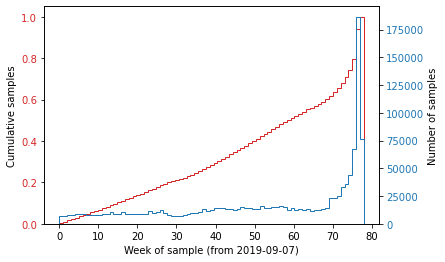

In [8]:
weekly_counts = skyhook_data.resample('7d', on='rq_time')['rq_time'].count()

cdf_color = 'tab:red'
hist_color = 'tab:blue'

num_bin = weekly_counts.shape[0]
fig, cdf_ax = plt.subplots()
cdf_ax.hist(np.arange(0,num_bin), num_bin, weights=weekly_counts, density=True, cumulative=True, histtype='step', color=cdf_color)
cdf_ax.tick_params(axis='y', labelcolor=cdf_color)
plt.ylabel("Cumulative samples")
plt.xlabel("Week of sample (from 2019-09-07)")

hist_ax = cdf_ax.twinx()

hist_ax.hist(np.arange(0,num_bin), num_bin, weights=weekly_counts, histtype='step', color=hist_color)
hist_ax.tick_params(axis='y', labelcolor=hist_color)
plt.ylabel("Number of samples")
plt.show()

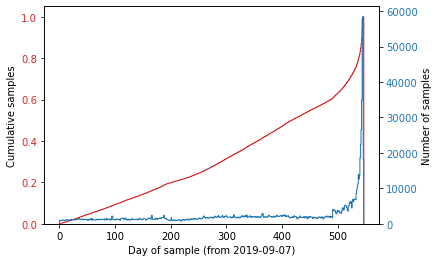

In [9]:

daily_counts = skyhook_data.resample('1d', on='rq_time')['rq_time'].count()

cdf_color = 'tab:red'
hist_color = 'tab:blue'

num_bin = daily_counts.shape[0]
fig, cdf_ax = plt.subplots()
cdf_ax.hist(np.arange(0,num_bin), num_bin, weights=daily_counts, density=True, cumulative=True, histtype='step', color=cdf_color)
cdf_ax.tick_params(axis='y', labelcolor=cdf_color)
plt.ylabel("Cumulative samples")
plt.xlabel("Day of sample (from 2019-09-07)")

hist_ax = cdf_ax.twinx()

hist_ax.hist(np.arange(0,num_bin), num_bin, weights=daily_counts, histtype='step', color=hist_color)
hist_ax.tick_params(axis='y', labelcolor=hist_color)
plt.ylabel("Number of samples")
plt.show()

In [10]:
area_data = skyhook_data['tide5id_100m'].groupby(skyhook_data['tide5id_100m']).count().sort_values()
frequency_count_measurement = area_data.groupby(area_data).count()

area_data.describe()


count    85510.000000
mean        15.106105
std         90.261841
min          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
max      17363.000000
Name: tide5id_100m, dtype: float64

In [11]:
frequency_count_measurement.describe()

count      598.000000
mean       142.993311
std       1266.646053
min          1.000000
25%          1.000000
50%          2.000000
75%         11.000000
max      26625.000000
Name: tide5id_100m, dtype: float64

Creating a CDF of non-empty tiles

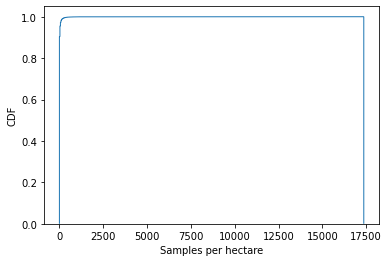

In [12]:
num_bin = frequency_count_measurement.shape[0]
fig, cdf_ax = plt.subplots()
cdf_ax.hist(frequency_count_measurement.index, num_bin, weights=frequency_count_measurement.values, density=True, cumulative=True, histtype='step')
plt.ylabel("CDF")
plt.xlabel("Samples per hectare")


plt.show()

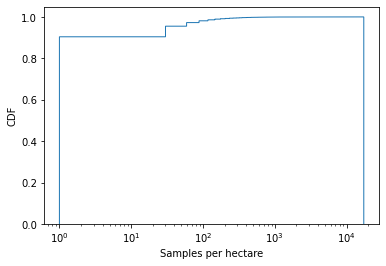

In [13]:
num_bin = frequency_count_measurement.shape[0]
fig, cdf_ax = plt.subplots()
cdf_ax.hist(frequency_count_measurement.index, num_bin, weights=frequency_count_measurement.values, density=True, cumulative=True, histtype='step')
plt.ylabel("CDF")
plt.xscale('log')
plt.xlabel("Samples per hectare")


plt.show()

# We see how this compares to the sample subset from the Hopi reservation.

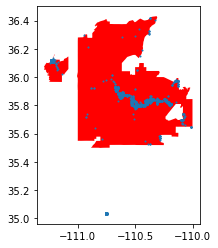

In [14]:
fig, ax = plt.subplots()

ax.set_aspect('equal')
hopi.plot(ax=ax, color='red')
skyhook_hopi.plot(ax=ax, markersize=1)
plt.show()

In [15]:
skyhook_hopi[['rq_time']].describe(datetime_is_numeric=True)

,rq_time
count,9403
mean,2020-10-16 12:15:57.448580096
min,2019-09-07 06:03:50
25%,2020-06-23 22:57:11
50%,2021-01-01 20:03:28
75%,2021-02-26 17:41:40
max,2021-03-07 23:38:58


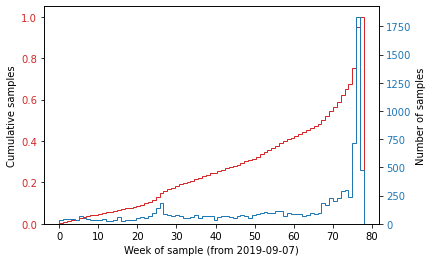

In [16]:
weekly_counts_hopi = skyhook_hopi.resample('7d', on='rq_time')['rq_time'].count()

cdf_color = 'tab:red'
hist_color = 'tab:blue'

num_bin = weekly_counts_hopi.shape[0]
fig, cdf_ax = plt.subplots()
cdf_ax.hist(np.arange(0,num_bin), num_bin, weights=weekly_counts_hopi, density=True, cumulative=True, histtype='step', color=cdf_color)
cdf_ax.tick_params(axis='y', labelcolor=cdf_color)
plt.ylabel("Cumulative samples")
plt.xlabel("Week of sample (from 2019-09-07)")

hist_ax = cdf_ax.twinx()

hist_ax.hist(np.arange(0,num_bin), num_bin, weights=weekly_counts_hopi, histtype='step', color=hist_color)
hist_ax.tick_params(axis='y', labelcolor=hist_color)
plt.ylabel("Number of samples")
plt.show()

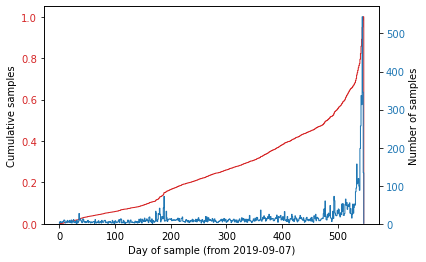

In [17]:

daily_counts_hopi = skyhook_hopi.resample('1d', on='rq_time')['rq_time'].count()

cdf_color = 'tab:red'
hist_color = 'tab:blue'

num_bin = daily_counts_hopi.shape[0]
fig, cdf_ax = plt.subplots()
cdf_ax.hist(np.arange(0,num_bin), num_bin, weights=daily_counts_hopi, density=True, cumulative=True, histtype='step', color=cdf_color)
cdf_ax.tick_params(axis='y', labelcolor=cdf_color)
plt.ylabel("Cumulative samples")
plt.xlabel("Day of sample (from 2019-09-07)")

hist_ax = cdf_ax.twinx()

hist_ax.hist(np.arange(0,num_bin), num_bin, weights=daily_counts_hopi, histtype='step', color=hist_color)
hist_ax.tick_params(axis='y', labelcolor=hist_color)
plt.ylabel("Number of samples")
plt.show()

In [18]:
area_data_hopi = skyhook_hopi['tide5id_100m'].groupby(skyhook_hopi['tide5id_100m']).count().sort_values()
frequency_count_measurement_hopi = area_data_hopi.groupby(area_data_hopi).count()

area_data_hopi.describe()

count    1521.000000
mean        6.182117
std        15.455338
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       258.000000
Name: tide5id_100m, dtype: float64

We see that we have a significantly lower mean and max number of samples per area in the Hopi reservation than in the global sample data.

In [19]:
frequency_count_measurement_hopi.describe()

count     60.000000
mean      25.350000
std       86.179518
min        1.000000
25%        1.000000
50%        3.500000
75%        9.000000
max      600.000000
Name: tide5id_100m, dtype: float64

Creating a CDF of non-empty tiles

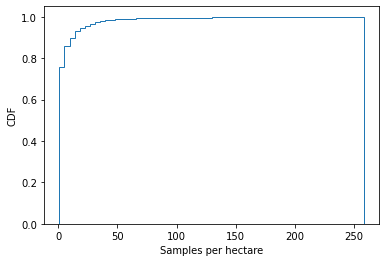

In [20]:
num_bin_hopi = frequency_count_measurement_hopi.shape[0]
fig, cdf_ax = plt.subplots()
cdf_ax.hist(frequency_count_measurement_hopi.index, num_bin_hopi, weights=frequency_count_measurement_hopi.values, density=True, cumulative=True, histtype='step')
plt.ylabel("CDF")
plt.xlabel("Samples per hectare")


plt.show()

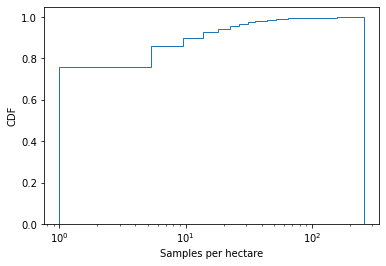

In [21]:
fig, cdf_ax = plt.subplots()
cdf_ax.hist(frequency_count_measurement_hopi.index, num_bin_hopi, weights=frequency_count_measurement_hopi.values, density=True, cumulative=True, histtype='step')
plt.ylabel("CDF")
plt.xscale('log')
plt.xlabel("Samples per hectare")


plt.show()

Unfortunately we can not derive empty tiles from this method because of the arbitrary nature of the tile IDs, so we will calculate the approximate proportion by finding our total measurement area and subtracting the area which contains measurements from our data set.

In [35]:
hopi_area = hopi['geometry'].to_crs({'proj':'cea'}).area/ 10**4
hopi_area = hopi_area.sum()


area_data_hopi.sum()/hopi_area

0.014332203869937271

Thus approximately only 1.4% of the Skyhook hectare tiles within the Hopi reservation have any signals recorded.

In [22]:
unique_ouis = skyhook_data['mac_oui'].drop_duplicates()

In [23]:
skyhook_data['mac_oui'].describe()

count     1291723
unique     422038
top        0080AE
freq        12792
Name: mac_oui, dtype: object

In [37]:
# this code should collect counts of OUI/week pairs, however the runtime is very long so I'm unsure it's functioning correctly.
# oui_daily_counts = skyhook_data.groupby('mac_oui').resample('7d', on='rq_time')['rq_time'].count()

skyhook_data

,tide5id_100m,mac_oui,ssid,lat,lon,rq_time,zcta,zcta_city,zcta_county,zcta_state,geometry
0,B00C1D205,AE88FD,NaN,35.189023,-111.654981,2019-10-03 19:31:54,86011,Flagstaff,Coconino,AZ,POINT (-111.65498 35.18902)
1,B00C1EFBD,AED818,NaN,35.245249,-111.564899,2020-02-07 14:23:53,86004,Flagstaff,Coconino,AZ,POINT (-111.56490 35.24525)
2,B00E15905,98415C,NaN,35.095134,-109.670705,2020-04-14 16:34:51,86502,Chambers,Apache,AZ,POINT (-109.67071 35.09513)
3,B00C1D29F,921B2D,NaN,35.198395,-111.648860,2019-10-20 20:20:37,86001,Flagstaff,Coconino,AZ,POINT (-111.64886 35.19840)
4,B00C1D32B,9245BA,NaN,35.190278,-111.629299,2019-10-17 01:14:02,86001,Flagstaff,Coconino,AZ,POINT (-111.62930 35.19028)
...,...,...,...,...,...,...,...,...,...,...,...
1291718,B17331F15,C26CD4,NaN,36.048597,-112.135089,2020-07-28 07:07:20,86023,Grand Canyon,Coconino,AZ,POINT (-112.13509 36.04860)
1291719,AEA53F23F,42490F,DIRECT-58-HP M426 LaserJet,34.190584,-110.016098,2021-03-04 22:16:13,85929,Lakeside,Navajo,AZ,POINT (-110.01610 34.19058)
1291720,B00C1E544,0A79EB,NaN,35.208758,-111.608667,2021-01-02 20:19:41,86004,Flagstaff,Coconino,AZ,POINT (-111.60867 35.20876)
1291721,AEA643A89,0A80AE,NaN,34.291875,-109.779849,2021-02-27 17:25:50,85940,Vernon,Apache,AZ,POINT (-109.77985 34.29187)


In [84]:
# weeks 0 - 70 proportion of OUIs vs weeks 70 - end proportion of OUIs
skyhook_time_sorted = skyhook_data.sort_values(by='rq_time')
skyhook_time_index = skyhook_time_sorted.set_index('rq_time')
first = skyhook_time_sorted['rq_time'].iloc[0]
last = skyhook_time_sorted['rq_time'].iloc[-1]
delta = last-first
# aribitrarily selected
proportion = 70/80
proportion_delta = delta * proportion

In [89]:
early_samples = skyhook_time_index[first:first+proportion_delta]
late_samples = skyhook_time_index[first+proportion_delta:last]

In [90]:
early_samples['mac_oui'].describe()

count     755287
unique    377746
top       0A80AE
freq        4335
Name: mac_oui, dtype: object

In [91]:
late_samples['mac_oui'].describe()

count     536436
unique     53850
top       0080AE
freq        8520
Name: mac_oui, dtype: object

We observe a much higher proportion of unique OUIs in the early samples than the late, with nearly half of them being unique, while in the late samples only 1/10 are unique.